In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import json
import networkx as nx
from pandas.io.json import json_normalize
from functools import reduce
from scipy import sparse

In [2]:
def col_json_to_dict(df, cols):
    "Transform the json values inside a column into list of dictionaries"
    transformed_df = df
    for col in cols:
        transformed_df = transformed_df.assign(**{col: df[col].apply(json.loads)})
    return transformed_df

In [3]:
def col_dict_to_set(df, col, key):
    "Create a set from the values of the dictionaries give a key"
    get_set = lambda dict_list: set([dict_.get(key) for dict_ in dict_list])
    return df.assign(**{col: df[col].apply(get_set)})

In [4]:
def col_filter_dict_with_vals(df, col, field, values):
    "Filter dictionaries with specific values from a column with lists of dictionaries"
    filter_dicts = lambda dict_list: [
        dict_ for dict_ in dict_list if dict_.get(field) in values
    ]
    return df.assign(**{col: df[col].apply(filter_dicts)})

In [5]:
credits_df = pd.read_csv("./data/tmdb_5000_credits.csv", sep=",", quotechar='"')
credits_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
movies_df = pd.read_csv("./data/tmdb_5000_movies.csv", sep=",", quotechar='"').rename(
    {"id": "movie_id"}, axis=1
)
movies_df.head()

,budget,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [7]:
credits_df_cp = credits_df.copy()
movies_df_cp = movies_df.copy()

## Clean movies_df_cp

In [8]:
# movies with empty genre field
len(movies_df_cp[movies_df_cp.astype(str)["genres"] == "[]"])

28

In [9]:
# movies with empty production_companies field
len(movies_df_cp[movies_df_cp.astype(str)["production_companies"] == "[]"])

351

In [10]:
# movies with empty production_companies field
len(movies_df_cp[movies_df_cp.astype(str)["production_countries"] == "[]"])

174

In [11]:
# movies with empty production_companies field
len(movies_df_cp[movies_df_cp.astype(str)["spoken_languages"] == "[]"])

86

## Process movies df

In [12]:
pr_movies_df = movies_df_cp
len(pr_movies_df)

4803

In [13]:
pr_movies_df.head()

,budget,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [14]:
# Transform json to list of dictionaries within cols
movies_df_json_cols = [
    "genres",
    "production_companies",
    "keywords",
    "production_countries",
    "spoken_languages",
]
cols_to_drop = ["homepage", "overview", "tagline", "original_title"]
key = "name"
movie_id_col = "movie_id"

pr_movies_df = col_json_to_dict(pr_movies_df, movies_df_json_cols)
for col in movies_df_json_cols:
    pr_movies_df = col_dict_to_set(pr_movies_df, col, key)
pr_movies_df = pr_movies_df.drop(columns=cols_to_drop)
pr_movies_df.head()

,budget,genres,movie_id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
0,237000000,"{Adventure, Fantasy, Science Fiction, Action}",19995,"{futuristic, alien planet, 3d, mind and soul, ...",en,150.437577,"{Lightstorm Entertainment, Ingenious Film Part...","{United States of America, United Kingdom}",2009-12-10,2787965087,162.0,"{Español, English}",Released,Avatar,7.2,11800
1,300000000,"{Adventure, Fantasy, Action}",285,"{afterlife, exotic island, east india trading ...",en,139.082615,"{Jerry Bruckheimer Films, Second Mate Producti...",{United States of America},2007-05-19,961000000,169.0,{English},Released,Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"{Adventure, Crime, Action}",206647,"{sequel, spy, mi6, united kingdom, based on no...",en,107.376788,"{Columbia Pictures, Danjaq, B24}","{United States of America, United Kingdom}",2015-10-26,880674609,148.0,"{Italiano, Español, Français, English, Deutsch}",Released,Spectre,6.3,4466
3,250000000,"{Thriller, Drama, Crime, Action}",49026,"{cat burglar, flood, crime fighter, superhero,...",en,112.312950,"{DC Entertainment, Legendary Pictures, Warner ...",{United States of America},2012-07-16,1084939099,165.0,{English},Released,The Dark Knight Rises,7.6,9106
4,260000000,"{Adventure, Science Fiction, Action}",49529,"{mars civilization, alien, martian, medallion,...",en,43.926995,{Walt Disney Pictures},{United States of America},2012-03-07,284139100,132.0,{English},Released,John Carter,6.1,2124


## Process credits df

In [15]:
pr_credits_df = credits_df_cp
credits_df_json_cols = ["cast", "crew"]
key = "name"
pr_credits_df = col_json_to_dict(pr_credits_df, credits_df_json_cols)
pr_credits_df = pr_credits_df.assign(actors=pr_credits_df[credits_df_json_cols[0]])
for col in credits_df_json_cols:
    if col != "crew":
        pr_credits_df = col_dict_to_set(pr_credits_df, col, key)
crew_col = "crew"
job_field = "job"
values = ["Director"]
# Filter dictionaries with Director as job
pr_credits_df = col_filter_dict_with_vals(
    pr_credits_df, crew_col, job_field, values
).rename({crew_col: values[0]})
pr_credits_df = col_dict_to_set(pr_credits_df, crew_col, key)
# Get actors col
# Only select main actors to reduce the size of the dataset
actors_col = "actors"
order_field = "order"
# Select the number of important actors
values = [0]
pr_credits_df = col_filter_dict_with_vals(
    pr_credits_df, actors_col, order_field, values
).rename({crew_col: values[0]})

get_value = lambda dict_: dict_.get(key)

pr_credits_df = pr_credits_df.explode(actors_col)
pr_credits_df = pr_credits_df[pr_credits_df[actors_col].notna()]
actors_series = pr_credits_df[actors_col]
pr_credits_df = pr_credits_df.assign(
    **{actors_col: pr_credits_df[actors_col].apply(get_value)}
)
# Remove actor from cast
actor_cast_col = "actor_cast"
pr_credits_df = pr_credits_df.reset_index(drop=True)
remove_from_cast = lambda row: row[credits_df_json_cols[0]] - set({row[actors_col]})
pr_credits_df = pr_credits_df.assign(
    **{credits_df_json_cols[0]: pr_credits_df.apply(remove_from_cast, axis=1)}
).drop(columns="title")
pr_credits_df.head()

,movie_id,cast,crew,actors
0,19995,"{April Marie Thomas, Colin Bleasdale, Dileep R...",{James Cameron},Sam Worthington
1,285,"{Jonathan Pryce, Takayo Fischer, Naomie Harris...",{Gore Verbinski},Johnny Depp
2,206647,"{Adel Bencherif, Noemi Krausz, Stephane Cornic...",{Sam Mendes},Daniel Craig
3,49026,"{Bill Cowher, Diogo Hausen, Claire Julien, Chr...",{Christopher Nolan},Christian Bale
4,49529,"{Bryan Cranston, Daryl Sabara, Willem Dafoe, L...",{Andrew Stanton},Taylor Kitsch


In [16]:
actor_cols = ["name", "gender", "order"]
actors_df = json_normalize(actors_series)[actor_cols]
actors_df = (
    actors_df.rename(columns={actor_cols[0]: actors_col})
    .groupby(actors_col)
    .aggregate({actor_cols[1]: max, actor_cols[2]: list})
    .reset_index()
    .reset_index()
    .rename(columns={"index": "actor_id"})
)
actors_df

,actor_id,actors,gender,order
0,0,"""Weird Al"" Yankovic",0,[0]
1,1,50 Cent,2,[0]
2,2,AJ Michalka,1,[0]
3,3,Aamir Khan,2,"[0, 0]"
4,4,Aaron Abrams,2,[0]
...,...,...,...,...
1966,1966,Zoe Kazan,1,[0]
1967,1967,Zoe Lister-Jones,1,[0]
1968,1968,Zoe Saldana,1,[0]
1969,1969,Zoe Sloane,0,[0]


In [17]:
actors_credits_df = pr_credits_df.merge(
    actors_df, right_on=actors_col, left_on=actors_col, how="inner"
)
actors_credits_df.head(20)

,movie_id,cast,crew,actors,actor_id,gender,order
0,19995,"{April Marie Thomas, Colin Bleasdale, Dileep R...",{James Cameron},Sam Worthington,1653,2,"[0, 0, 0, 0]"
1,57165,"{Lily James, Bill Nighy, Sinéad Cusack, Edgar ...",{Jonathan Liebesman},Sam Worthington,1653,2,"[0, 0, 0, 0]"
2,18823,"{Jane March, Phil McKee, Nathalie Cox, Natalia...",{Louis Leterrier},Sam Worthington,1653,2,"[0, 0, 0, 0]"
3,49527,"{Frank Anello, Derrick T. Lewis, Liz Holtan, R...",{Asger Leth},Sam Worthington,1653,2,"[0, 0, 0, 0]"
4,285,"{Jonathan Pryce, Takayo Fischer, Naomie Harris...",{Gore Verbinski},Johnny Depp,926,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,58,"{Alex Norton, Luke de Woolfson, Jonathan Pryce...",{Gore Verbinski},Johnny Depp,926,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,57201,"{Tom Wilkinson, Damon Herriman, Chad Randall, ...",{Gore Verbinski},Johnny Depp,926,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,1865,"{Ian McShane, Stephen Graham, Roger Allam, Ste...",{Rob Marshall},Johnny Depp,926,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,241259,"{Toby Jones, Jamie Baughan, Neil Edmond, Minou...",{James Bobin},Johnny Depp,926,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,118,"{Tony Kirwood, Chris Cresswell, Oscar James, G...",{Tim Burton},Johnny Depp,926,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
movie_id_col = "movie_id"
new_movie_id_col = "new_movie_id"
actors_movies_credits_df = actors_credits_df.merge(
    pr_movies_df, right_on=movie_id_col, left_on=movie_id_col, how="inner"
)
# Set new movie ids
unique_movies_df = (
    pr_movies_df[movie_id_col]
    .to_frame()
    .drop_duplicates()
    .reset_index()
    .rename(columns={"index": new_movie_id_col})
)
actors_movies_credits_df = (
    actors_movies_credits_df.merge(
        unique_movies_df, right_on=movie_id_col, left_on=movie_id_col, how="inner"
    )
    .drop(columns=movie_id_col)
    .rename(columns={new_movie_id_col: movie_id_col})
)

actors_movies_credits_df.head()

,cast,crew,actors,actor_id,gender,order,budget,genres,keywords,original_language,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,movie_id
0,"{April Marie Thomas, Colin Bleasdale, Dileep R...",{James Cameron},Sam Worthington,1653,2,"[0, 0, 0, 0]",237000000,"{Adventure, Fantasy, Science Fiction, Action}","{futuristic, alien planet, 3d, mind and soul, ...",en,...,"{United States of America, United Kingdom}",2009-12-10,2787965087,162.0,"{Español, English}",Released,Avatar,7.2,11800,0
1,"{Lily James, Bill Nighy, Sinéad Cusack, Edgar ...",{Jonathan Liebesman},Sam Worthington,1653,2,"[0, 0, 0, 0]",150000000,{Adventure},"{zeus, based on greek myth, ares, gods, hades,...",en,...,"{United States of America, Spain}",2012-03-27,301000000,99.0,{English},Released,Wrath of the Titans,5.5,1431,132
2,"{Jane March, Phil McKee, Nathalie Cox, Natalia...",{Louis Leterrier},Sam Worthington,1653,2,"[0, 0, 0, 0]",125000000,"{Adventure, Fantasy, Action}","{zeus, based on greek myth, kraken, gods, hade...",en,...,{United States of America},2010-04-01,232713139,106.0,{English},Released,Clash of the Titans,5.6,2233,206
3,"{Frank Anello, Derrick T. Lewis, Liz Holtan, R...",{Asger Leth},Sam Worthington,1653,2,"[0, 0, 0, 0]",42000000,"{Thriller, Crime, Action}","{diamond heist, framed for a crime, rooftop, n...",en,...,{United States of America},2012-01-13,46221189,102.0,{English},Released,Man on a Ledge,6.2,925,1146
4,"{Jonathan Pryce, Takayo Fischer, Naomie Harris...",{Gore Verbinski},Johnny Depp,926,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",300000000,"{Adventure, Fantasy, Action}","{afterlife, exotic island, east india trading ...",en,...,{United States of America},2007-05-19,961000000,169.0,{English},Released,Pirates of the Caribbean: At World's End,6.9,4500,1


In [19]:
aux_movies_df = unique_movies_df.merge(
    pr_movies_df[["movie_id", "title"]].drop_duplicates(),
    right_on="movie_id",
    left_on="movie_id",
)
aux_movies_df.head()

,new_movie_id,movie_id,title
0,0,19995,Avatar
1,1,285,Pirates of the Caribbean: At World's End
2,2,206647,Spectre
3,3,49026,The Dark Knight Rises
4,4,49529,John Carter


In [20]:
actors_movies_credits_df.columns

Index(['cast', 'crew', 'actors', 'actor_id', 'gender', 'order', 'budget',
       'genres', 'keywords', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title',
       'vote_average', 'vote_count', 'movie_id'],
      dtype='object')

In [21]:
len(actors_movies_credits_df)

4581

In [22]:
get_union = lambda s: reduce(set.union, s)
actor_id_col = "actor_id"
actors_agg_df = (
    actors_movies_credits_df.groupby(actors_col)
    .aggregate(
        {
            "movie_id": set,
            "cast": get_union,
            "crew": get_union,
            "actor_id": max,
            "gender": max,
            "budget": "mean",
            "genres": get_union,
            "keywords": get_union,
            "original_language": set,
            "popularity": "mean",
            "production_companies": get_union,
            "production_countries": get_union,
            "release_date": list,
            "revenue": "mean",
            "runtime": sum,
            "spoken_languages": get_union,
            "status": list,
            "title": set,
            "vote_average": "mean",
            "vote_count": "mean",
        }
    )
    .set_index(actor_id_col)
)
actors_agg_df.head()

,movie_id,cast,crew,gender,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
actor_id,,,,,,,,,,,,,,,,,,,
0,{3619},"{David Bowe, Kevin McCarthy, Emo Philips, Fran...",{Jay Levey},0,5000000.0,{Comedy},"{tv station, music video, music spoof, game sh...",{en},4.070044,"{Orion Pictures, Cinecorp}",{United States of America},[1989-07-21],0.0,97.0,{English},[Released],{UHF},6.7,89.0
1,{1233},"{Omar Benson Miller, Adewale Akinnuoye-Agbaje,...",{Jim Sheridan},2,40000000.0,{Drama},"{attempted murder, musical, loss of mother, ra...",{en},12.885985,"{MTV Films, Paramount Pictures, Cent Productio...",{United States of America},[2005-11-09],46442528.0,117.0,{English},[Released],{Get Rich or Die Tryin'},6.3,186.0
2,{4203},"{James Denton, Emma Catherwood, Kevin Pollak, ...",{Brad J. Silverman},1,0.0,"{Drama, Music}",{christian},{en},2.160586,"{Birchwood Pictures, Coram Deo Studios}",{United States of America},[2013-10-04],0.0,102.0,{English},[Released],{Grace Unplugged},6.0,24.0
3,"{3543, 1023}","{Kulbhushan Kharbanda, Arif Zakaria, Eric Pete...","{Deepa Mehta, Rakeysh Omprakash Mehra}",2,1100000.0,{Drama},"{students' movement, partition, woman director...",{hi},3.226925,"{Flicks Motion Pictures, Cracking the Earth Fi...","{India, Canada}","[1998-09-16, 2006-01-26]",6015561.5,258.0,{हिन्दी},"[Released, Released]","{Rang De Basanti, Earth}",6.9,53.0
4,{2242},"{Alan Alda, Lauren Graham, Tim Kelleher, Tatia...",{Marc Abraham},2,0.0,{Drama},{biography},{en},3.350297,"{Universal Pictures, Strike Entertainment, Spy...",{United States of America},[2008-09-07],0.0,119.0,{English},[Released],{Flash of Genius},6.3,59.0


## Build graph

In [23]:
nodes_df = actors_agg_df[["cast", "crew", "production_companies", "genres", "movie_id"]]
nodes_df.head()

,cast,crew,production_companies,genres,movie_id
actor_id,,,,,
0,"{David Bowe, Kevin McCarthy, Emo Philips, Fran...",{Jay Levey},"{Orion Pictures, Cinecorp}",{Comedy},{3619}
1,"{Omar Benson Miller, Adewale Akinnuoye-Agbaje,...",{Jim Sheridan},"{MTV Films, Paramount Pictures, Cent Productio...",{Drama},{1233}
2,"{James Denton, Emma Catherwood, Kevin Pollak, ...",{Brad J. Silverman},"{Birchwood Pictures, Coram Deo Studios}","{Drama, Music}",{4203}
3,"{Kulbhushan Kharbanda, Arif Zakaria, Eric Pete...","{Deepa Mehta, Rakeysh Omprakash Mehra}","{Flicks Motion Pictures, Cracking the Earth Fi...",{Drama},"{3543, 1023}"
4,"{Alan Alda, Lauren Graham, Tim Kelleher, Tatia...",{Marc Abraham},"{Universal Pictures, Strike Entertainment, Spy...",{Drama},{2242}


In [24]:
dict_actor_id = dict(zip(actors_df[actors_col], actors_df[actor_id_col]))
dict_id_actor = dict(zip(actors_df[actor_id_col], actors_df[actors_col]))

## Get cast intersecctions length mat

In [25]:
import timeit


def get_intersections_length_adj_mat(col):
    "Get the intersecction length of the set of each entry with the set of every other entry in the column"
    start = timeit.default_timer()
    adj = np.zeros((col.shape[0], col.shape[0]))
    for (i, set_row) in enumerate(col):
        for (j, set_col) in enumerate(col):
            try:
                adj[i, j] = len(set_row.intersection(set_col))
            except AttributeError:
                adj[i, j] = 0
    stop = timeit.default_timer()
    print("Time: ", stop - start)
    return adj

In [26]:
def get_unions_length_adj_mat(col):
    "Get the unions length of the set of each entry with the set of every other entry in the column"
    start = timeit.default_timer()
    adj = np.zeros((col.shape[0], col.shape[0]))
    for (i, set_row) in enumerate(col):
        for (j, set_col) in enumerate(col):
            try:
                adj[i, j] = len(set_row.union(set_col))
            except AttributeError:
                adj[i, j] = 0
    stop = timeit.default_timer()
    print("Time: ", stop - start)
    return adj

## Get cast intersections

In [27]:
col = "cast"
cast_col = nodes_df[col]
cast_adj_raw = get_intersections_length_adj_mat(cast_col)
cast_adj_diag = np.diag(np.diag(cast_adj_raw))
cast_adj = cast_adj_raw - cast_adj_diag

Time:  3.633344674000001


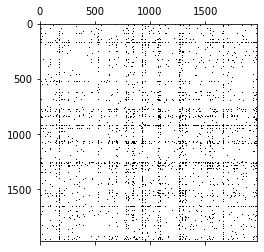

In [28]:
plt.spy(cast_adj)

In [29]:
np.save("cast_adj", cast_adj)

## Load cast adjacency matrix

In [30]:
cast_adj = np.load("cast_adj.npy")

In [31]:
cast_adj.shape

(1971, 1971)

In [32]:
node_degree = cast_adj.sum(axis=0)

In [33]:
most_connected_actors_id = np.argsort(-node_degree)[:20]
most_connected_actors = [dict_id_actor.get(id_) for id_ in most_connected_actors_id]
actors_df[actors_df[actor_id_col].isin(most_connected_actors_id)]
print(most_connected_actors)

['Bruce Willis', 'Johnny Depp', 'Denzel Washington', 'Ben Stiller', 'Tom Hanks', 'Nicolas Cage', 'Tom Cruise', 'Ben Affleck', 'Robert De Niro', 'George Clooney', 'Mark Wahlberg', 'Matt Damon', 'Leonardo DiCaprio', 'Christian Bale', 'Harrison Ford', 'Will Ferrell', 'Will Smith', 'Adam Sandler', 'John Travolta', 'Kevin Costner']


## Get cast unions length mat

In [34]:
col = "cast"
cast_col = nodes_df[col]
cast_adj_union_raw = get_unions_length_adj_mat(cast_col)
cast_adj_union_diag = np.diag(np.diag(cast_adj_union_raw))
cast_adj_union = cast_adj_union_raw - cast_adj_union_diag

Time:  12.495566950999999


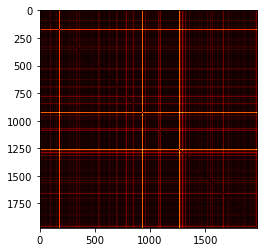

In [35]:
plt.imshow(cast_adj_union, cmap="hot", interpolation="none")

In [36]:
np.save("cast_adj_union", cast_adj_union)

## Get movies intersections length mat

In [37]:
col = "movie_id"
movie_col = nodes_df[col]
movie_adj_raw = get_intersections_length_adj_mat(movie_col)
movie_adj_diag = np.diag(np.diag(movie_adj_raw))
movie_adj = movie_adj_raw - movie_adj_diag

Time:  1.7683923770000014


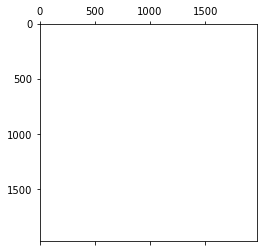

In [38]:
plt.spy(movie_adj)

In [39]:
np.save("movie_adj", movie_adj)

## Get movies union length mat

In [40]:
col = "movie_id"
movie_col = nodes_df[col]
movie_adj_union_raw = get_unions_length_adj_mat(movie_col)
movie_adj_union_diag = np.diag(np.diag(movie_adj_union_raw))
movie_adj_union = movie_adj_union_raw - movie_adj_union_diag

Time:  2.081847691


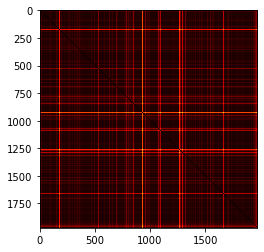

In [41]:
plt.imshow(movie_adj_union, cmap="hot", interpolation="none")

In [42]:
np.save("movie_adj_union", movie_adj_union)

## Get directors intersections lenght mat

In [43]:
col = "crew"
crew_col = nodes_df[col]
crew_adj_raw = get_intersections_length_adj_mat(crew_col)
crew_adj_diag = np.diag(np.diag(crew_adj_raw))
crew_adj = crew_adj_raw - crew_adj_diag

Time:  1.7957613200000004


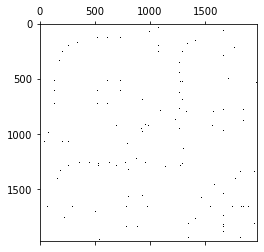

In [44]:
plt.spy(crew_adj)

In [45]:
np.save("crew_adj", crew_adj)

## Get directors union length mat

In [46]:
col = "crew"
crew_col = nodes_df[col]
crew_adj_union_raw = get_unions_length_adj_mat(crew_col)
crew_adj_union_diag = np.diag(np.diag(crew_adj_union_raw))
crew_adj_union = crew_adj_union_raw - crew_adj_union_diag

Time:  2.249620412999999


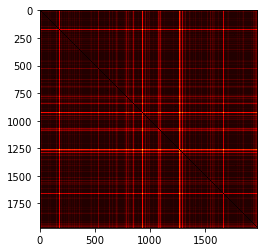

In [47]:
plt.imshow(crew_adj_union, cmap="hot", interpolation="none")

In [48]:
np.save("crew_adj_union", crew_adj_union)

## Get production companies intersections length mat

In [49]:
col = "production_companies"
prod_comp_col = nodes_df[col]
prod_comp_adj_raw = get_intersections_length_adj_mat(prod_comp_col)
prod_comp_adj_diag = np.diag(np.diag(prod_comp_adj_raw))
prod_comp_adj = prod_comp_adj_raw - prod_comp_adj_diag

Time:  2.109672463999999


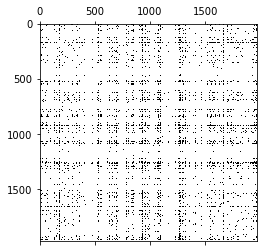

In [50]:
plt.spy(prod_comp_adj)

In [51]:
np.save("prod_comp_adj", prod_comp_adj)

## Get production companies unions length mat

In [52]:
col = "production_companies"
prod_comp_col = nodes_df[col]
prod_comp_adj_union_raw = get_unions_length_adj_mat(prod_comp_col)
prod_comp_adj_union_diag = np.diag(np.diag(prod_comp_adj_union_raw))
prod_comp_adj_union = prod_comp_adj_union_raw - prod_comp_adj_union_diag

Time:  4.080618467000001


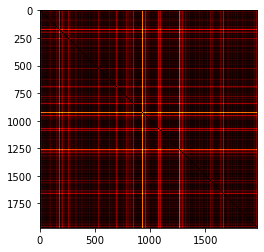

In [53]:
plt.imshow(prod_comp_adj_union, cmap="hot", interpolation="none")

In [54]:
np.save("prod_comp_adj_union", prod_comp_adj_union)

## Get genres intersections length mat

In [55]:
col = "genres"
genres_col = nodes_df[col]
genres_adj_raw = get_intersections_length_adj_mat(genres_col)
genres_adj_diag = np.diag(np.diag(genres_adj_raw))
genres_adj = genres_adj_raw - genres_adj_diag

Time:  2.439012875000003


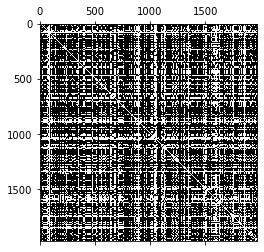

In [56]:
plt.spy(genres_adj)

In [57]:
np.save("genres_adj", genres_adj)

## Get genres unions length mat

In [58]:
col = "genres"
genres_col = nodes_df[col]
genres_adj_union_raw = get_unions_length_adj_mat(genres_col)
genres_adj_union_diag = np.diag(np.diag(genres_adj_union_raw))
genres_adj_union = genres_adj_union_raw - genres_adj_union_diag

Time:  3.134671355000002


In [ ]:
plt.imshow(genres_adj_union, cmap="hot", interpolation="none")

In [ ]:
np.save("genres_adj_union", genres_adj_union)

## Aggregated adjacency matrix

In [ ]:
agg_adj = np.divide(
    (
        0.3 * cast_adj
        + 0.3 * movie_adj
        + 0.2 * crew_adj
        + 0.1 * genres_adj
        + 0.1 * prod_comp_adj
    ),
    (
        0.3 * cast_adj_union
        + 0.3 * movie_adj_union
        + 0.2 * crew_adj_union
        + 0.1 * genres_adj_union
        + 0.1 * prod_comp_adj_union
    ),
)
agg_adj = np.where(np.isnan(agg_adj), 0, agg_adj)
np.sum(agg_adj)

In [ ]:
plt.spy(agg_adj)

In [ ]:
plt.imshow(agg_adj, cmap="hot", interpolation="none")

In [ ]:
np.min(agg_adj)

In [ ]:
np.max(agg_adj)

In [ ]:
np.save("agg_adj", agg_adj)

## Sparsify graph

In [ ]:
agg_adj = np.load("agg_adj.npy")

In [ ]:
def sparsify_adj(adj,epsilon):
    return np.where(adj<=epsilon,0,adj)

In [ ]:
percentile = 70
eps = np.percentile(agg_adj,70)
print(eps)

In [ ]:
sparse_agg_adj = sparsify_adj(agg_adj,eps)

In [ ]:
plt.spy(sparse_agg_adj)

In [ ]:
actors_graph = nx.from_numpy_matrix(sparse_agg_adj)


In [ ]:
csr_sparse_agg_adj = sparse.csr_matrix(sparse_agg_adj)

## Tests

### Test consistency of data

In [ ]:
dict_actor_id.get("Sam Worthington")

In [ ]:
actors_df[actors_df["actors"] == "Adriana Barraza"]

In [ ]:
dict_actor_id.get("Andreas Berg")

In [ ]:
actors_df[actors_df["actor_id"] == 1000]

In [ ]:
nodes_df.loc[0, "cast"]

In [ ]:
# Test number of actors
len(np.unique(actors_agg_df.index.values))

In [ ]:
actors_agg_df

In [ ]:
test_movie_id = actors_agg_df.loc[dict_actor_id.get("Sam Worthington")]["movie_id"]
test_movie_id

In [ ]:
test_movies_df = unique_movies_df[
    unique_movies_df[new_movie_id_col].isin(test_movie_id)
]
test_movies_df = test_movies_df.merge(
    pr_movies_df, right_on=movie_id_col, left_on=movie_id_col
)
test_movies_df[[movie_id_col, new_movie_id_col, "title"]]

In [ ]:
"Sam Worthington" in pr_credits_df.loc[0, "cast"]

In [ ]:
pr_credits_df.loc[0]